# CA5

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

### Reading data

In [2]:
train_df = pd.DataFrame(pd.read_csv("train.csv"))
test_df = pd.DataFrame(pd.read_csv("test.csv"))

train_df[:10], train_df.size, test_df.size

(   Length (cm)  Width (cm)  Weight (g)  Pericarp Thickness (mm)  Seed Count  \
 0        17.37        5.42       94.30                     4.90      193.93   
 1        27.78        4.75      262.71                     6.56      186.29   
 2         6.17        3.51       66.72                     7.96      298.81   
 3         6.12        6.07       51.24                     4.57       39.36   
 4        28.58        4.84      166.51                     3.07      194.07   
 5        13.80        8.64      189.24                     4.32       72.27   
 6         9.15        8.40       74.69                     1.70        8.45   
 7        12.40       10.68      159.72                    10.28      239.54   
 8        18.90        7.66       57.72                     4.63       87.10   
 9        35.57        8.82      633.31                     6.92      244.27   
 
    Capsaicin Content  Vitamin C Content (mg)  Sugar Content  Moisture Content  \
 0               3.21               

In [3]:
train_df.dtypes

Length (cm)                                          float64
Width (cm)                                           float64
Weight (g)                                           float64
Pericarp Thickness (mm)                              float64
Seed Count                                           float64
Capsaicin Content                                    float64
Vitamin C Content (mg)                               float64
Sugar Content                                        float64
Moisture Content                                     float64
Firmness                                             float64
color                                                 object
Harvest Time                                          object
Average Daily Temperature During Growth (celcius)    float64
Average Temperature During Storage (celcius)          object
Scoville Heat Units (SHU)                            float64
dtype: object

I see that there are three columns with categorical values - these need to be altered to numerical values for the classifier to be able to calculate results. I investigate these columns further:

### Data cleaning

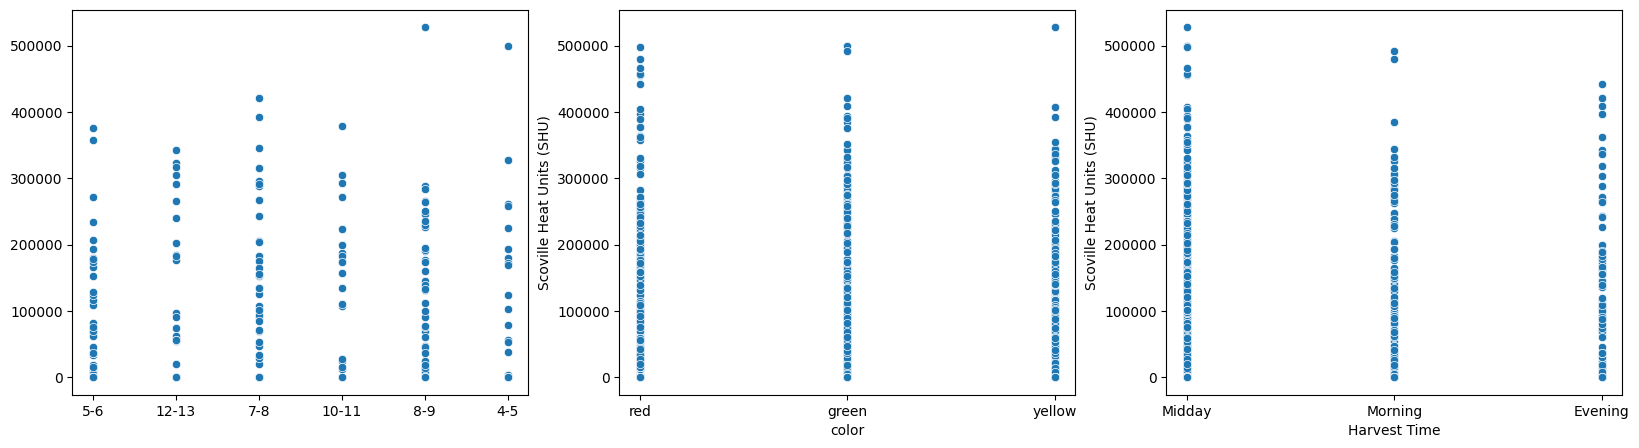

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(x=train_df["Average Temperature During Storage (celcius)"].values, y=train_df["Scoville Heat Units (SHU)"].values, ax=ax[0])
sns.scatterplot(x=train_df["color"], y=train_df["Scoville Heat Units (SHU)"], ax=ax[1])
sns.scatterplot(x=train_df["Harvest Time"], y=train_df["Scoville Heat Units (SHU)"], ax=ax[2])
plt.show()

In [5]:
"""
Since the categorical features show so little correlation with the target variable, I decide to remove the columns "Average Temperature During
Storage (celsius)" and "Harvest Time". Logically, it seems unlikely that storage temperature and harvest time should have an impact on spice.
Moreover, the plots show no direct correlation between these variables and the target variable, and the storage temperature column has very many NaN-values.
Alternatively, I could have altered the values to numerical, e.g. by setting the value of temperature to the mean (5.5 for 5-6) and giving the 
time-of-day variable index labels - if they had proven themselves useful. However, I decide to keep the colour-column for now, as it could
be somehow descriptive in combination with other physical features. I'll then assign index labels (0, 1, 2) to the colours.
"""

columns_to_drop = ["Average Temperature During Storage (celcius)", "Harvest Time"]
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

colour_mapping = {"red": 0, "green": 1, "yellow": 2}
train_df["color"] = train_df["color"].replace(colour_mapping)
test_df["color"] = test_df["color"].replace(colour_mapping)
print(train_df.dtypes)

train_df["Scoville Heat Units (SHU)"].max()

Length (cm)                                          float64
Width (cm)                                           float64
Weight (g)                                           float64
Pericarp Thickness (mm)                              float64
Seed Count                                           float64
Capsaicin Content                                    float64
Vitamin C Content (mg)                               float64
Sugar Content                                        float64
Moisture Content                                     float64
Firmness                                             float64
color                                                float64
Average Daily Temperature During Growth (celcius)    float64
Scoville Heat Units (SHU)                            float64
dtype: object


C:\Users\kroel\AppData\Local\Temp\ipykernel_16668\2006965858.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["color"] = train_df["color"].replace(colour_mapping)
C:\Users\kroel\AppData\Local\Temp\ipykernel_16668\2006965858.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df["color"] = test_df["color"].replace(colour_mapping)


527639.86

In [6]:
train_df.isnull().sum(), test_df.isnull().sum()

(Length (cm)                                          1
 Width (cm)                                           1
 Weight (g)                                           1
 Pericarp Thickness (mm)                              2
 Seed Count                                           1
 Capsaicin Content                                    1
 Vitamin C Content (mg)                               0
 Sugar Content                                        1
 Moisture Content                                     0
 Firmness                                             1
 color                                                1
 Average Daily Temperature During Growth (celcius)    0
 Scoville Heat Units (SHU)                            0
 dtype: int64,
 Length (cm)                                          2
 Width (cm)                                           0
 Weight (g)                                           0
 Pericarp Thickness (mm)                              0
 Seed Count                      

### Data preprocessing and visualisation

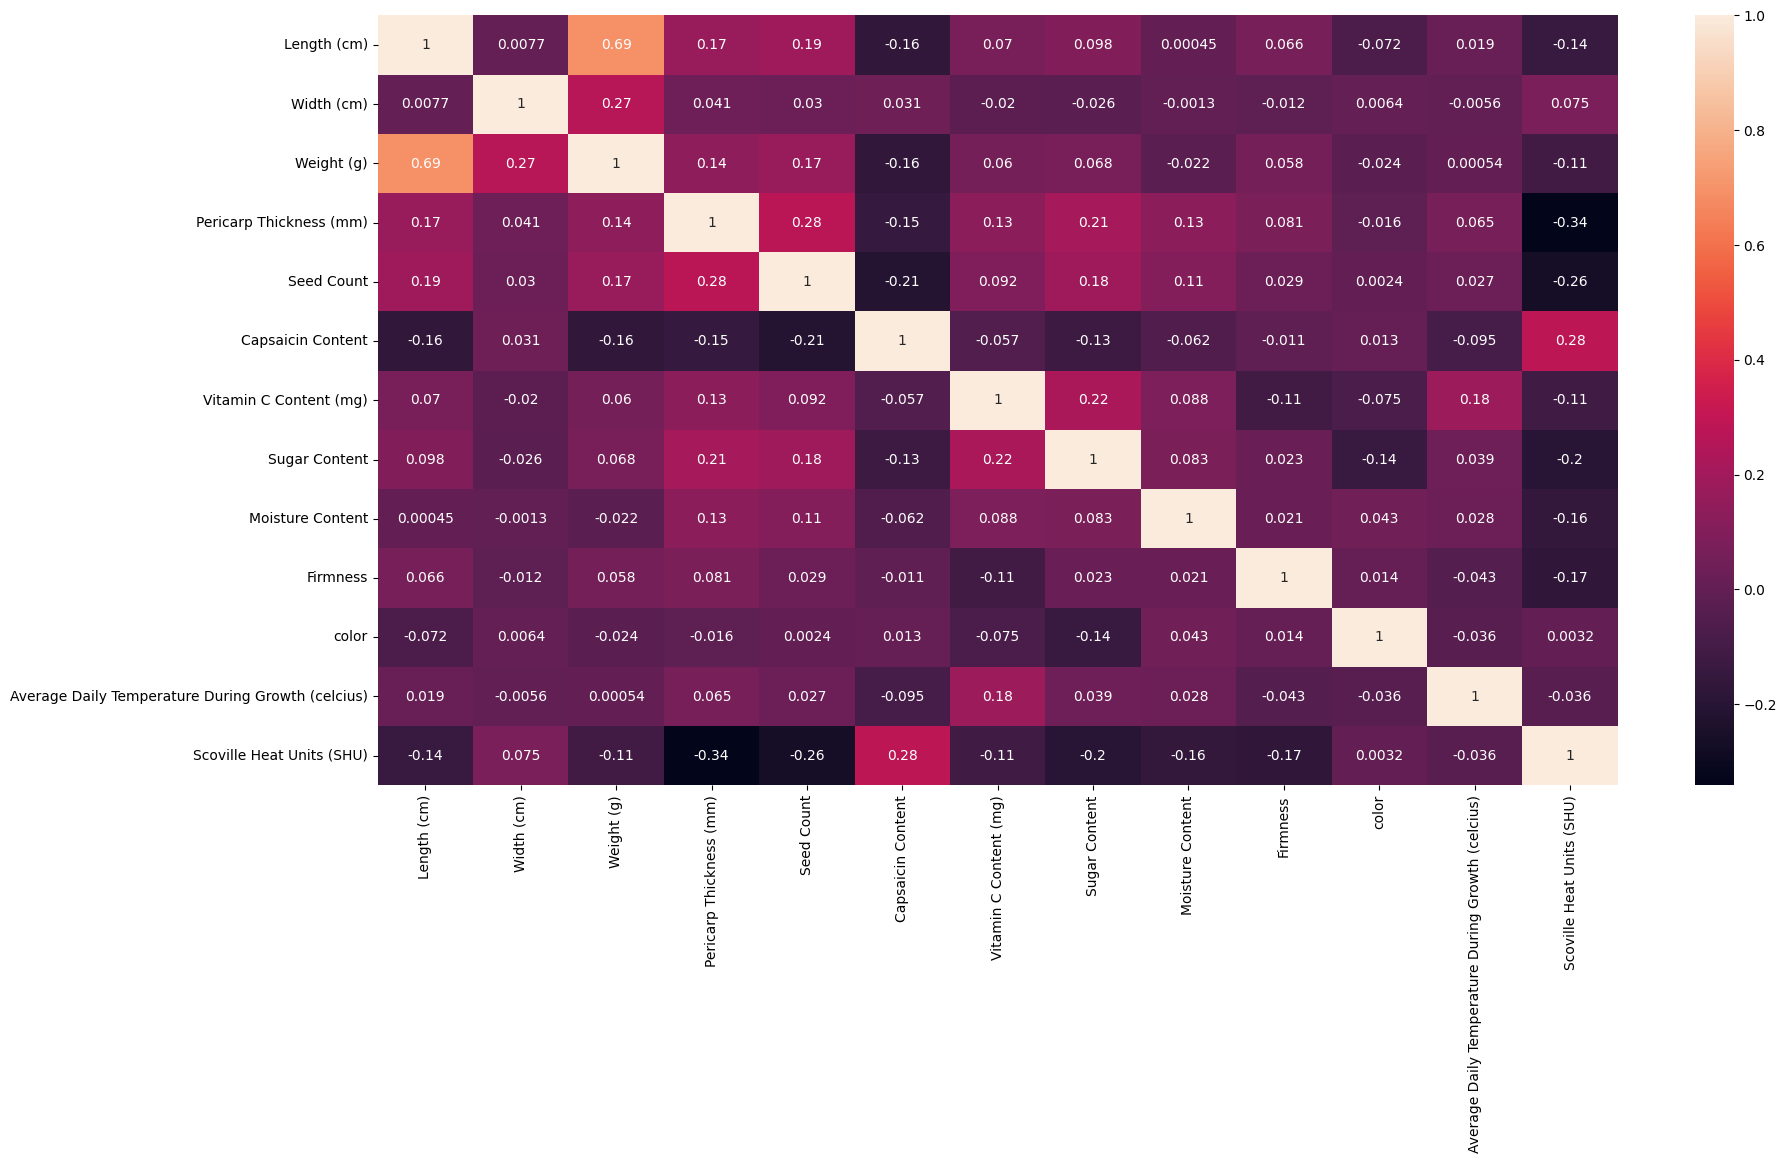

In [7]:
# Linear correlation map
plt.figure(figsize=(20, 10))
sns.heatmap(train_df.corr(), annot=True)
plt.show()

The linear correlation plot shows no significant linear correlation between any features of interest. I move on by plotting scatterplots of the target column together with the other columns to check for other kinds of correlation.

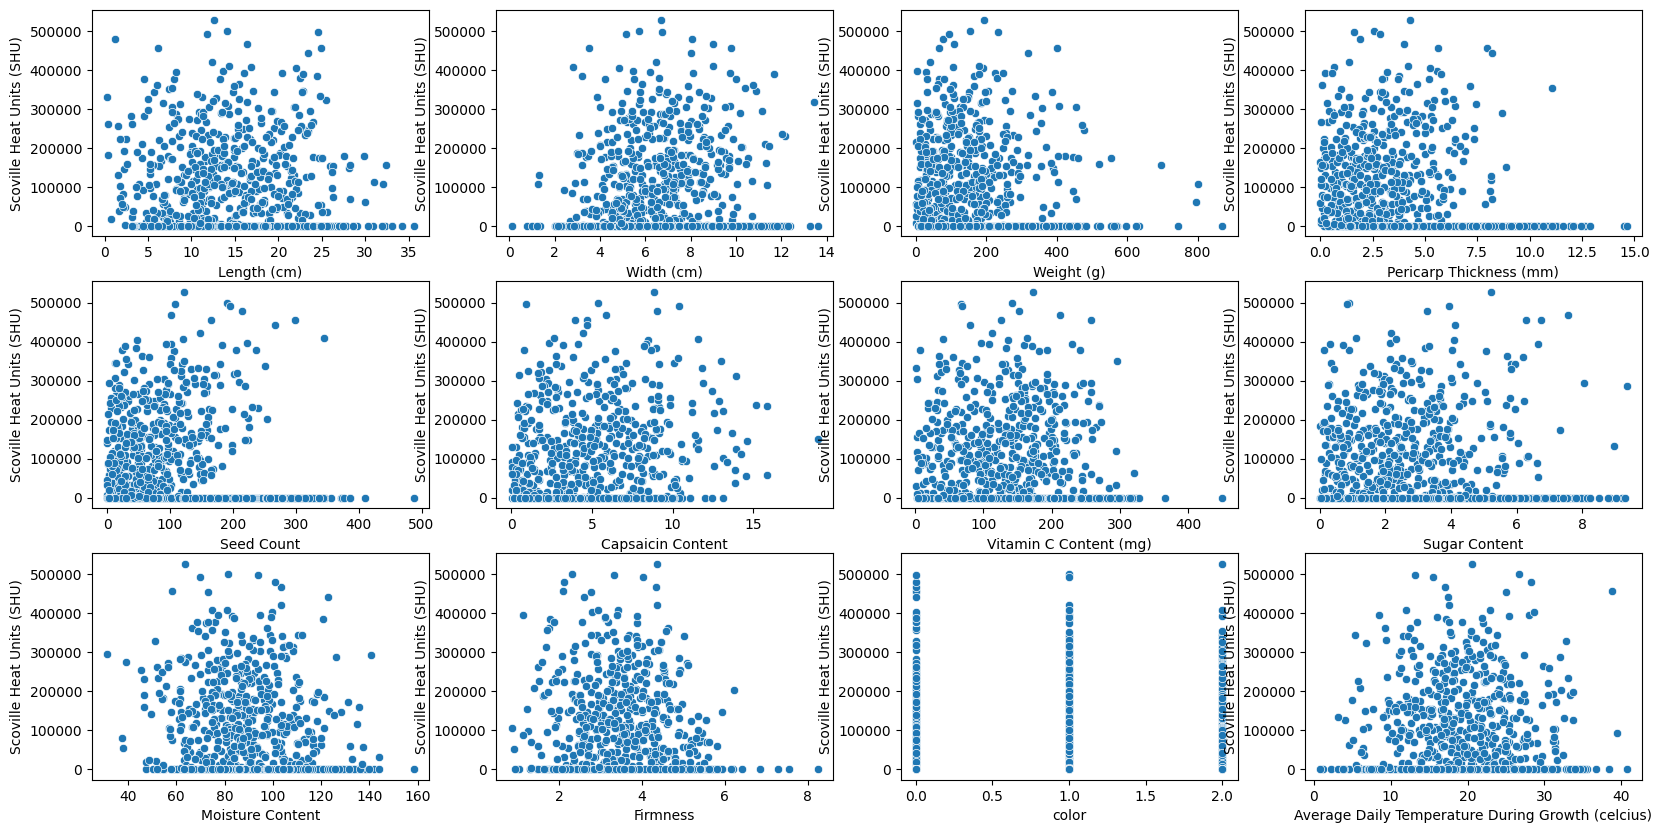

Index(['Length (cm)', 'Width (cm)', 'Weight (g)', 'Pericarp Thickness (mm)',
       'Seed Count', 'Capsaicin Content', 'Vitamin C Content (mg)',
       'Sugar Content', 'Moisture Content', 'Firmness', 'color',
       'Average Daily Temperature During Growth (celcius)',
       'Scoville Heat Units (SHU)'],
      dtype='object')

In [8]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
plot_row = 0
plot_column = 0
for feature in train_df.columns.drop("Scoville Heat Units (SHU)"):
    if feature == "Scoville Heat Units (SHU)":
        pass
    sns.scatterplot(x=train_df[feature], y=train_df["Scoville Heat Units (SHU)"], ax=ax[plot_row, plot_column])
    if plot_column == 3:
        plot_column = 0
        plot_row += 1
    else:
        plot_column += 1
plt.show()

train_df.columns

### Comments on the visualisation ###
There seem to be no features here that are immediately revealing as to where the peppers spice is located on the Scoville scale, so I cannot draw any immediate conclusions on what further simplifications or alterations may be done to the dataset.

### Train / dev split ###

In [9]:
"""
This is sort of a sketchy move, but I 
""" 

def binary_mapping(value):
    return 1 if value > 0 else 0

y = train_df["Scoville Heat Units (SHU)"].values
X = train_df.drop("Scoville Heat Units (SHU)", axis=1).values

train_df_gt0 = train_df[train_df["Scoville Heat Units (SHU)"] != 0]

y_gt0 = train_df_gt0["Scoville Heat Units (SHU)"].values
X_gt0 = train_df_gt0.drop("Scoville Heat Units (SHU)", axis=1).values

X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size=0.7, random_state=42)

y_train_binary = np.array([binary_mapping(value) for value in y_train])
y_dev_binary = np.array([binary_mapping(value) for value in y_dev])

X.size, X_gt0.size

(12000, 5508)

### Modelling

In [10]:
"""
Setting up pipelines with my chosen classifiers - before this final set, I tried to include both LDA and PCA in the pipelines.
PCA just made the results worse, or made no difference at all, whereas LDA screwed up the classifiers (or at least prevented them from doing
their job).
"""

# Regression analysis
pls = Pipeline([
    ('imputer', SimpleImputer()),
    ('pls', PLSRegression())
])

# Ensemble classifier
xgb = Pipeline([
    ('pca', PCA()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer),
    ('xgb', XGBRegressor(objective='reg:squarederror', n_jobs=-1))
])

# Simple linear regression
lgr = Pipeline([
    ('imputer', SimpleImputer()),
    ('lr', LinearRegression(n_jobs=-1))
])

print(f"PLS parameters: {pls.get_params()}")
print(f"XGBoost parameters: {xgb.get_params()}")

PLS parameters: {'memory': None, 'steps': [('imputer', SimpleImputer()), ('pls', PLSRegression())], 'verbose': False, 'imputer': SimpleImputer(), 'pls': PLSRegression(), 'imputer__add_indicator': False, 'imputer__copy': True, 'imputer__fill_value': None, 'imputer__keep_empty_features': False, 'imputer__missing_values': nan, 'imputer__strategy': 'mean', 'pls__copy': True, 'pls__max_iter': 500, 'pls__n_components': 2, 'pls__scale': True, 'pls__tol': 1e-06}


TypeError: BaseEstimator.get_params() missing 1 required positional argument: 'self'

In [ ]:
# Setting up ranges for RandomizedSearch and GidSearch with cross-validation
estimators = np.linspace(1, 1300, 1300, dtype=int)
depths = np.linspace(1, 15, 15, dtype=int)
learning_rates = np.linspace(0, 1, 10)

print(estimators, depths, learning_rates)

pls_grid = {"pls__n_components": components}

xgb_grid = {"xgb__n_estimators": estimators, "xgb__max_depth": depths, "xgb__eta": learning_rates}

[   1    2    3 ... 1298 1299 1300] [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


In [ ]:
"""
Setting up the GridSearches and RandomizedSearches - I use RandomizedSearch on models that use more or less continuous hyperparameter-ranges,
and GridSearch on the ones whose hyperparameters are tuned with discrete values.
"""
pls_search = GridSearchCV(estimator=pls,
                          param_grid=pls_grid,
                          scoring='neg_mean_absolute_error',
                          cv=10,
                          n_jobs=-1,
                          verbose=2)

xgb_search = RandomizedSearchCV(estimator=xgb,
                                param_distributions=xgb_grid,
                                scoring='neg_mean_absolute_error',
                                n_iter=100,
                                cv=10,
                                n_jobs=-1,
                                verbose=2)

lr_search = GridSearchCV(estimator=lr,
                        param_grid={},
                        scoring='neg_mean_absolute_error',
                        cv=10,
                        n_jobs=-1,
                        verbose=2)

In [ ]:
searches = {"PLS": pls_search, "XGBoost": xgb_search, "Linear Regression": lr_search}
for search in searches:
    searches[search].fit(X_train, y_train)
    print(f'Best parameters for {search}: {searches[search].best_params_}')
    print(f'Best score for {search}: {abs(searches[search].best_score_)}')


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for PLS: {'pls__n_components': 2}
Best score for PLS: 68191.02565355867
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters for XGBoost: {'xgb__n_estimators': 211, 'xgb__max_depth': 11, 'xgb__eta': 0.1111111111111111}
Best score for XGBoost: 68024.07520338328
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters for Linear Regression: {}
Best score for Linear Regression: 68453.15840894058


### Final evaluation

In [ ]:
best_model = xgb_search.best_estimator_
y_pred_xgb = best_model.predict(X_dev)
print(f"Final mean absolute error: {mean_absolute_error(y_dev, y_pred_xgb)}")

Final mean absolute error: 66097.96735173566


### Kaggle submission

In [ ]:
best_model.fit(X, y)
X_test = test_df.values
y_pred = best_model.predict(X_test)

submission_df = pd.DataFrame(y_pred, columns=['Scoville Heat Units (SHU)'])
submission_df.to_csv("XGBRegressor.csv", index_label="index")